# Nice to Meat You: An Analysis on Meat Consumption

## Introduction

In this notebook, we familiarize ourselves with the Dunnhumby dataset. To do so, we first explore and analyse the four files that are useful to answer our research questions; namely <em>hh_demographic.csv, product.csv, transactions_data.csv and coupon.csv</em>.

For each of those, we first perform exloratory analysis (size, missing, values, ...) and then create new colums and tables necessary to conduct our analysis. Finally, we look for more specific insights that are relevant for our project. At the end, We also expand our analysis by combining several datasets.

The goal is to get as familiar as possible with the Dunnhumby data and all its subtleties to make sure it is possible to answer our research questions on the basis of the dataset. 

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px 

default_figsize = (12.8, 4.8)

## Analysis of Household Demographics

In [2]:
df_household = pd.read_csv('dunnhumby/hh_demographic.csv', sep = ',')
df_household.head()

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U      25-34K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

In [3]:
# correct dtypes
df_household['AGE_DESC'] = pd.Categorical(df_household['AGE_DESC'].values, categories=['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True)
df_household['MARITAL_STATUS_CODE'] = df_household['MARITAL_STATUS_CODE'].astype('category')
df_household['INCOME_DESC'] = pd.Categorical(df_household['INCOME_DESC'].values, \
    categories=['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'], \
    ordered=True)
df_household['HOMEOWNER_DESC'] =  df_household['HOMEOWNER_DESC'].astype('category')
df_household['HH_COMP_DESC'] = df_household['HH_COMP_DESC'].astype('category')
df_household['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(df_household['HOUSEHOLD_SIZE_DESC'].values, categories=['1', '2', '3', '4', '5+'], ordered=True)
df_household['KID_CATEGORY_DESC'] = pd.Categorical(df_household['KID_CATEGORY_DESC'].values, categories=['None/Unknown', '1', '2', '3+'], ordered=True)
df_household.dtypes

AGE_DESC               category
MARITAL_STATUS_CODE    category
INCOME_DESC            category
HOMEOWNER_DESC         category
HH_COMP_DESC           category
HOUSEHOLD_SIZE_DESC    category
KID_CATEGORY_DESC      category
household_key             int64
dtype: object

### Exploratory Analysis

In [4]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_household), len(df_household.columns))) 

There are 801 rows and 8 columns in the dataset.


In [5]:
print('Number of columns with missing values is {0}.'.format(len(df_household.columns.to_numpy()[df_household.isna().any()])))

Number of columns with missing values is 0.


In [6]:
print('Columns:')
print('--------')
for col in df_household.columns:
    print(col)

Columns:
--------
AGE_DESC
MARITAL_STATUS_CODE
INCOME_DESC
HOMEOWNER_DESC
HH_COMP_DESC
HOUSEHOLD_SIZE_DESC
KID_CATEGORY_DESC
household_key


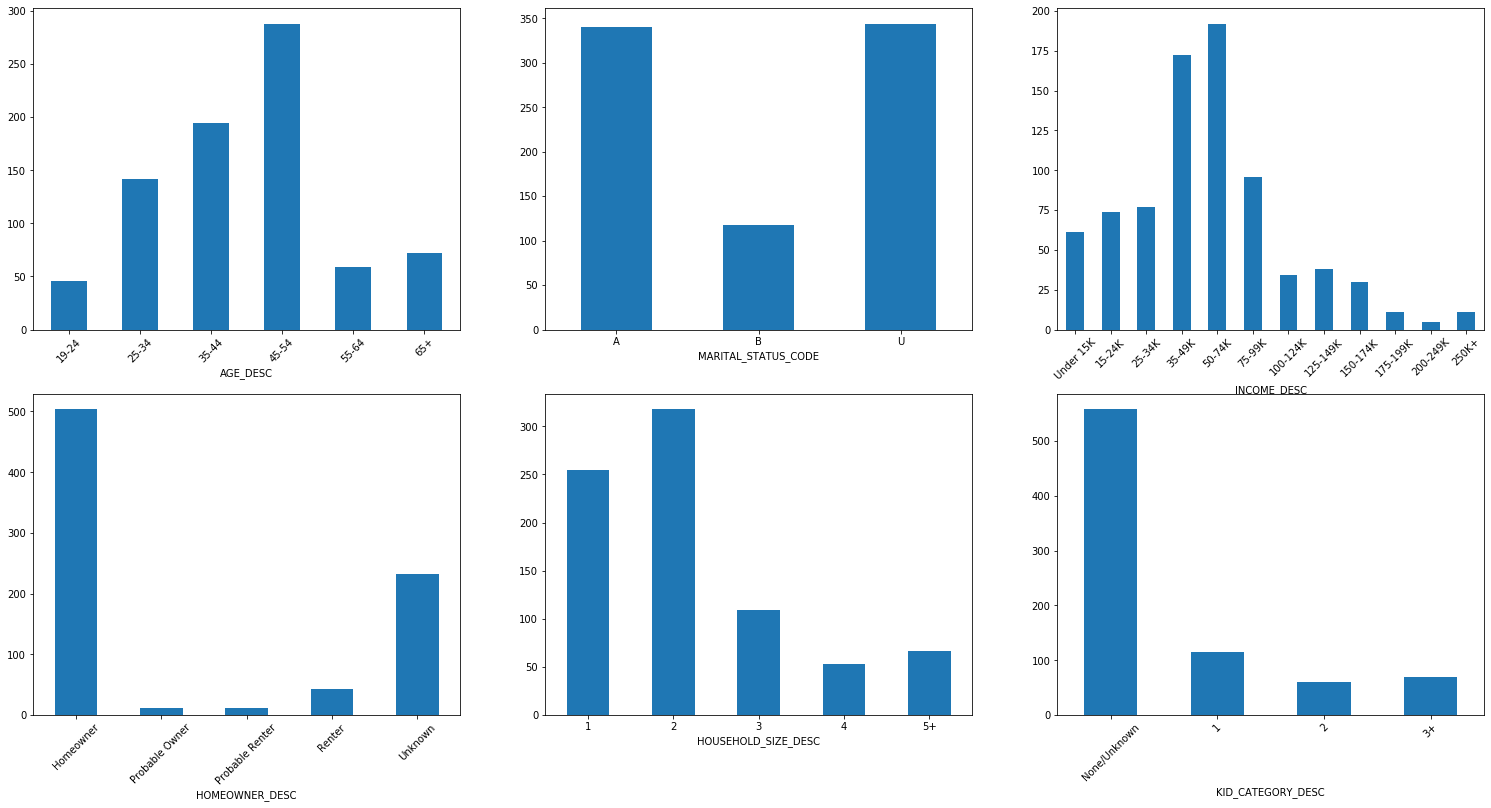

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, n in enumerate(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']):
    df_household.groupby(n)['household_key'].count().plot.bar(ax=axes[i // 3,i % 3])
    
    if i in [0, 2, 3, 5]:
        axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=45)
    else:
        axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=0)    

From the graph above we realise that income ranges above 100K and below 35 are not represented by large numbers. Thus, we decided to merge them to have more concrete result in our further analysis.

In [8]:
# merge some categories to have more households in them
cat_to_combine_over100K = ["100-124K", "125-149K", "150-174K", "175-199K", "200-249K", "250K+"]
cat_to_combine_under35K = ["Under 15K", "15-24K", "25-34K"]
def combine_cat(x):
    if x in cat_to_combine_over100K:
        return "100K+" 
    elif x in cat_to_combine_under35K:
        return "Under 35K"
    else: 
        return x
    
df_household['INCOME_DESC'] = df_household['INCOME_DESC'].apply(combine_cat)
df_household.INCOME_DESC.unique()

array(['35-49K', '50-74K', 'Under 35K', '75-99K', '100K+'], dtype=object)

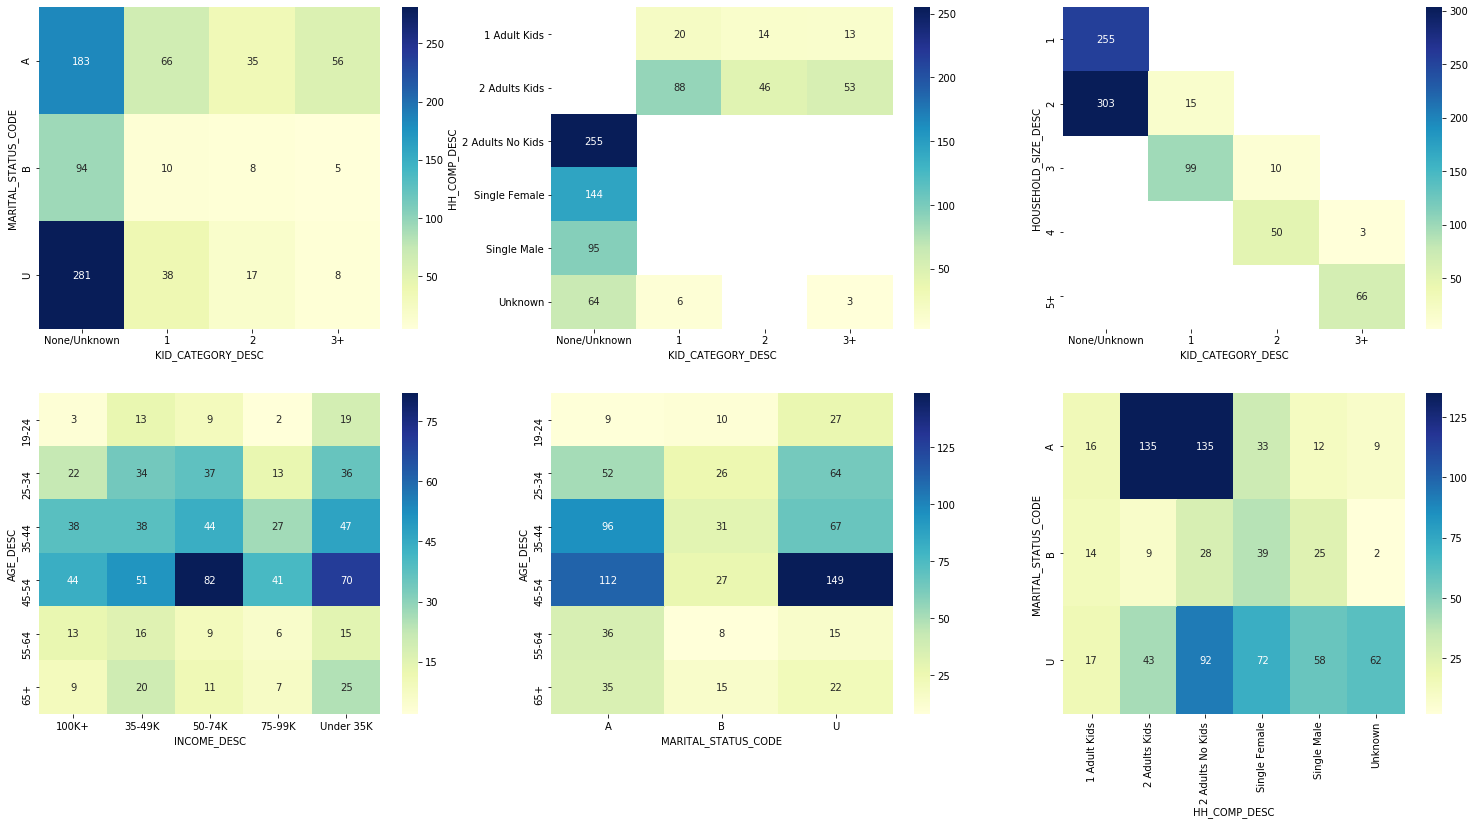

In [9]:
tuples = [ ('MARITAL_STATUS_CODE', 'KID_CATEGORY_DESC'),
 ('HH_COMP_DESC', 'KID_CATEGORY_DESC'),
 ('HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'),
 ('AGE_DESC', 'INCOME_DESC'),
 ('AGE_DESC', 'MARITAL_STATUS_CODE'),
 ('MARITAL_STATUS_CODE', 'HH_COMP_DESC')]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, t in enumerate(tuples):
    df_dummy = df_household.groupby([t[0], t[1]]).count()\
        .reset_index().pivot(index= t[0], columns= t[1], values='household_key')
    
    sns.heatmap(df_dummy, annot=True, fmt=".0f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i // 3,i % 3])
    
    b, t = axes[i // 3,i % 3].set_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    axes[i // 3,i % 3].set_ylim(b, t) # update the ylim(bottom, top) values

In general, we have found the distributions expected. Specifically, we observed that there are 64 housholds with unknown family info. Moreover, there are households with only one male and female so that we can apply some cross-gender analysis in individual level. 

In [10]:
# add new usefull columns

# for gender column
def create_gender_column(row):
    if row['HH_COMP_DESC'] == 'Single Female':
        return 'Female'
    elif row['HH_COMP_DESC'] == 'Single Male':
        return 'Male'
    else:
        return None

# for faimly_info_exist column
def create_family_info_column(row):
    return not (row['HH_COMP_DESC'] == 'Unknown' and row['KID_CATEGORY_DESC'] == 'None/Unknown')

# create columns
df_household['GENDER'] = df_household.apply (lambda row: create_gender_column(row), axis=1)
df_household['FAMILY_INFO_EXIST'] = df_household.apply (lambda row: create_family_info_column(row), axis=1)

df_household.head()

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U   Under 35K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  GENDER  \
0                   2      None/Unknown              1    None   
1                   2      None/Unknown              7    None   
2                   3                 1              8    None   
3                   4                 2             13    None   
4                   1      None/Unknown             16  Female   

   FAMILY_INFO_EXIST  
0               True  
1               True  
2               True  
3               True  
4               True

## Analysis of Products

In [11]:
df_products = pd.read_csv('dunnhumby/product.csv', sep = ',')
df_products.head()

PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION                       
2         BREAD:ITALIAN/FRENCH                       
3                  APPLE SAUCE                50 OZ  
4            SPECIALTY COOKIES                14 OZ

In [12]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_products), len(df_products.columns))) 

There are 92353 rows and 7 columns in the dataset.


In [13]:
print('Number of columns with missing values is {0}.'.format(len(df_products.columns.to_numpy()[df_products.isna().any()])))

Number of columns with missing values is 0.


In [14]:
print('Columns:')
print('--------')
for col in df_products.columns:
    print(col)

Columns:
--------
PRODUCT_ID
MANUFACTURER
DEPARTMENT
BRAND
COMMODITY_DESC
SUB_COMMODITY_DESC
CURR_SIZE_OF_PRODUCT


In [15]:
print('There are {0} unique products distributed in {1} different departments.'.format(len(df_products['PRODUCT_ID'].unique()), len(df_products['DEPARTMENT'].unique())))

There are 92353 unique products distributed in 44 different departments.


After some investigation, the COMMODITY_DESC column is not using a standardized notation despite such a standardization existing (see [here](https://unstats.un.org/unsd/tradekb/Knowledgebase/50018/Harmonized-Commodity-Description-and-Coding-Systems-HS)).

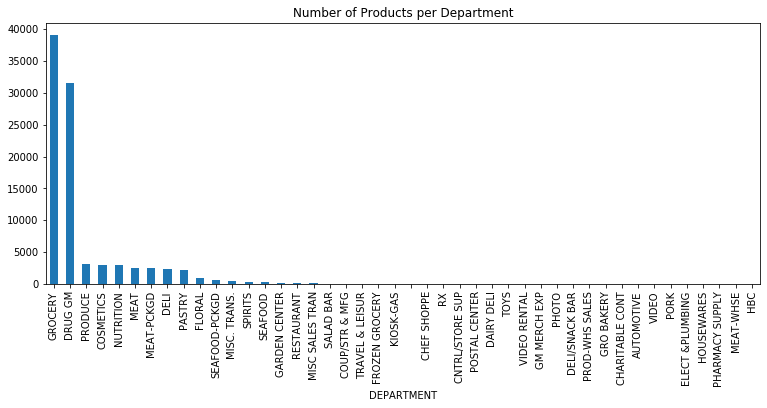

In [16]:
df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Products per Department');

In [17]:
percent = int(len(df_products[df_products.DEPARTMENT == 'GROCERY']) * 100 / len(df_products))
print(f'The GROCERY department contains nearly {percent}% of the products in the food sector.')

The GROCERY department contains nearly 42% of the products in the food sector.


### Food Products

For this project, the main interest is food products. Therefore, a dataframe with only food-related departments is created.

In [18]:
df_food_products = pd.read_csv('data/food_products.csv')

In [19]:
print('There are {0} unique food products distributed in {1} different departments.'.format(len(df_food_products['PRODUCT_ID'].unique()), len(df_food_products['DEPARTMENT'].unique())))

There are 51341 unique food products distributed in 18 different departments.


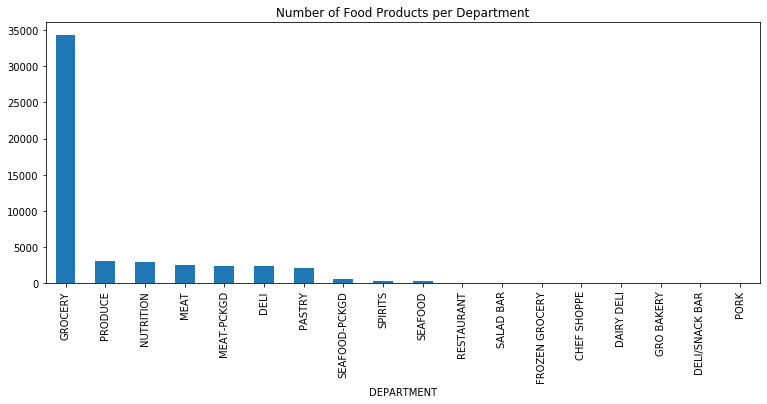

In [20]:
df_food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Food Products per Department');

In [21]:
percent = int(len(df_food_products[df_food_products.DEPARTMENT == 'GROCERY']) * 100 / len(df_food_products))
print(f'The GROCERY department contains nearly {percent}% of the products in the food sector.')

The GROCERY department contains nearly 66% of the products in the food sector.


### Products containing meat

In [22]:
df_meat_products = pd.read_csv('data/meat_products.csv')

In [23]:
print('There are {0} unique meat products distributed in {1} different departments.'.format(len(df_meat_products['PRODUCT_ID'].unique()), len(df_meat_products['DEPARTMENT'].unique())))

There are 8785 unique meat products distributed in 10 different departments.


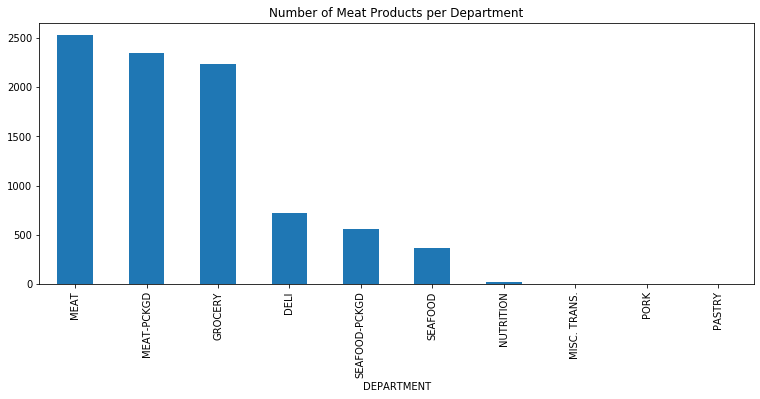

In [24]:
df_meat_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Meat Products per Department');

### Vegetables products

In [25]:
df_veggies_prducts = pd.read_csv('data/vegetables_products.csv')

In [26]:
print('There are {0} unique vegetable products distributed in {1} different departments.'.format(len(df_veggies_prducts['PRODUCT_ID'].unique()), len(df_veggies_prducts['DEPARTMENT'].unique())))

There are 3209 unique vegetable products distributed in 7 different departments.


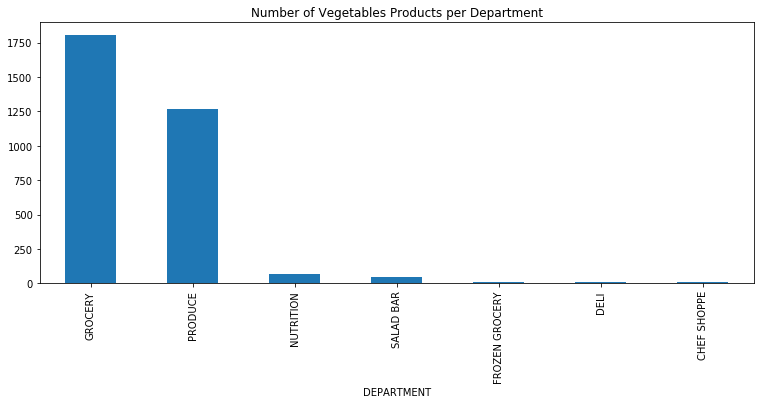

In [27]:
df_veggies_prducts.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Vegetables Products per Department');

## Analysis of Transactions

This csv file contains more than 2 million transactions. Each transactiction is identified by a household, a product id and a basket id.

In [28]:
# Load the dataset
df_transactions = pd.read_csv('dunnhumby/transaction_data.csv', sep = ',')
df_transactions.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0

In [29]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_transactions), len(df_transactions.columns))) 

There are 2595732 rows and 12 columns in the dataset.


In [30]:
print('Number of columns with missing values is {0}.'.format(len(df_transactions.columns.to_numpy()[df_transactions.isna().any()])))

Number of columns with missing values is 0.


In [31]:
print('Columns:')
print('--------')
for col in df_transactions.columns:
    print(col)

Columns:
--------
household_key
BASKET_ID
DAY
PRODUCT_ID
QUANTITY
SALES_VALUE
STORE_ID
RETAIL_DISC
TRANS_TIME
WEEK_NO
COUPON_DISC
COUPON_MATCH_DISC


The column named SALES_VALUE does not represent what a client paid for a product. It represents the raw value of a product that does not take into account the potential discounts. To be able to analyse the expenses of the customers we want to create a column PAID_PRICE that contains the actual amount that the customer paid. 

The paid price is calculated as follows :

PAID_PRICE = (SALES_VALUE - ( |RETAIL_DISC| + |COUPON_MATCH_DISC|)) 

In [32]:
df_transactions["PAID_PRICE"] = (df_transactions.SALES_VALUE - (df_transactions.RETAIL_DISC.abs() + df_transactions.COUPON_MATCH_DISC.abs()))
df_transactions["PAID_PRICE"] = df_transactions["PAID_PRICE"].clip(lower=0)
df_transactions.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  \
0       364        -0.60        1631        1          0.0                0.0   
1       364         0.00        1631        1          0.0                0.0   
2       364        -0.30        1631        1          0.0                0.0   
3       364         0.00        1631        1          0.0                0.0   
4       364        -0.39        1631        1          0.0                0.0   

   PAID_PRICE  
0        0.79  
1        0.82  
2        0.69  
3        1.21  
4        1.11

We found [a github project](https://github.com/Lanbig/CSC465-visualization-project) in which the author makes a calendar visualization of the Dunnhumby dataset. According to him, the day 1 corresponds to 24th of march 2010.

We create a new column containing the date in the dataframe :

In [33]:
start_date = datetime(2010, 3, 24)
def convert_day_to_date(day):
    date = start_date + timedelta(days=day-1)
    return date

df_transactions["DATE"] = df_transactions.DAY.apply(convert_day_to_date)

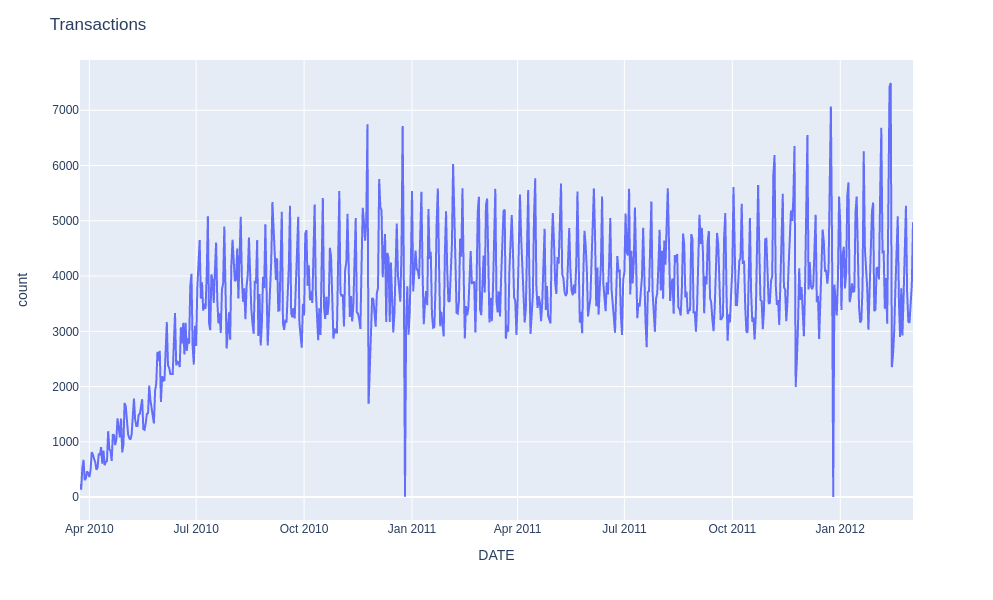

In [34]:
trans_per_day = df_transactions.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
fig = px.line(trans_per_day, x='DATE', y='count')
fig.update_layout(title="Transactions")
fig.show()

We observe a peak in the number of transactions on 24th of December and a low on the 26th which is a holiday. This makes us confident that  the start date that we found is correct.

If we look only at the transactions for Turkey meat (see below), we observe two peaks around the 20th of November which corresponds to Thanksgiving. As this is a US specific holiday. We think that the dataset might have been collected in the US.

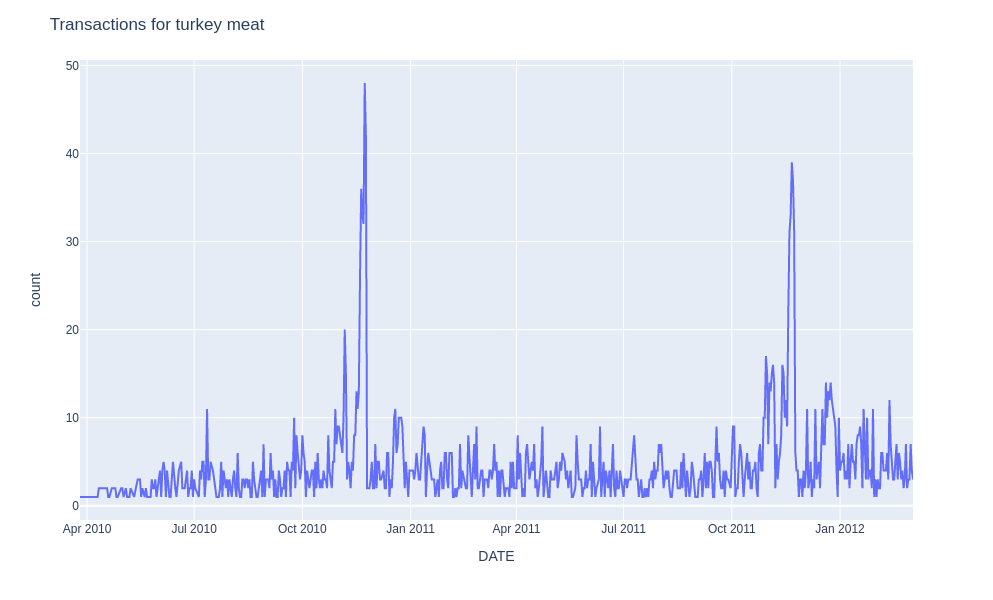

In [35]:
# Get turkey transactions
df_turkey_meat = df_meat_products[df_meat_products.COMMODITY_DESC.str.contains("TURKEY")]
df_turkey_meat_transactions = pd.merge(df_turkey_meat, df_transactions, on="PRODUCT_ID", how="inner")
trans_per_day_turkey = df_turkey_meat_transactions.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
# Plot
fig = px.line(trans_per_day_turkey, x='DATE', y='count')
fig.update_layout(title="Transactions for turkey meat")
fig.show()

#### Time column

In [36]:
print(f"Minimum value for the TRANS_TIME: {df_transactions.TRANS_TIME.min()}")
print(f"Maximum value for the TRANS_TIME: {df_transactions.TRANS_TIME.max()}")

Minimum value for the TRANS_TIME: 0
Maximum value for the TRANS_TIME: 2359


This column actually contains the time a which the transaction took place. The time is represented by an integer between 0 and 2359 that respectively corresponds to midnight and 23:59.  

We only keep the transactions related to food prodcuts for the rest of the analysis.

In [37]:
food_products_IDs = df_food_products.PRODUCT_ID.values
df_food_transactions = df_transactions[df_transactions.PRODUCT_ID.isin(food_products_IDs)]

In [38]:
print(f"The dataframe contains {len(df_food_transactions)} transactions.")

The dataframe contains 2130905 transactions.


In [39]:
print(f"The dataframe contains {len(df_food_transactions.BASKET_ID.unique())} baskets.")

The dataframe contains 225792 baskets.


### Basket Prices

To get an idea of how the people consume in the dataset, we are interested in knowing what is the distribution of the basket prices.

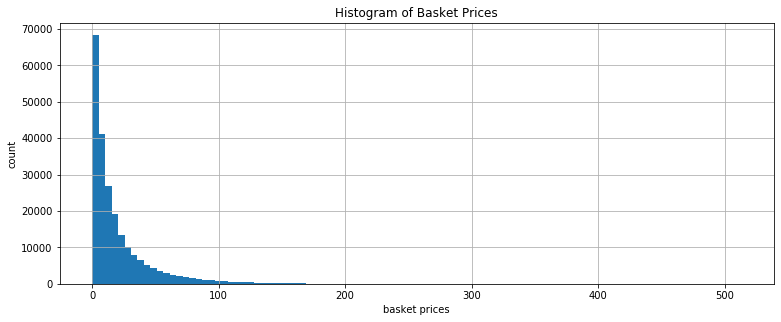

In [40]:
df_food_transactions.groupby("BASKET_ID").PAID_PRICE.sum().hist(bins=100,figsize=default_figsize)
plt.xlabel('basket prices')
plt.ylabel('count')
plt.title('Histogram of Basket Prices');

In [41]:
basket_prices = df_transactions.groupby("BASKET_ID").PAID_PRICE.sum()
print(f"The median basket price is {round(basket_prices.median(), 2)} $.")

The median basket price is 14.29 $.


It seems that the basket price follows a exponential distribution. We can plot it on a semi-log scale :

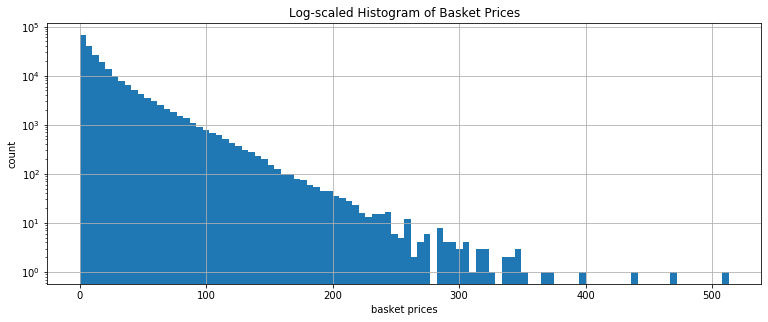

In [42]:
df_food_transactions.groupby("BASKET_ID").PAID_PRICE.sum().hist(bins=100, figsize=default_figsize)
plt.yscale("log")
plt.xlabel('basket prices')
plt.ylabel('count')
plt.title('Log-scaled Histogram of Basket Prices');

We see that there are some baskets that cost 0 dollars. Let's have a look at one of those baskets :

In [43]:
free_products = len(df_food_transactions[df_food_transactions.PAID_PRICE == 0])
percent_free_products = round(free_products * 100 / len(df_food_transactions), 2)
print(f"There are {free_products} products that were bought for free which is {percent_free_products}% of food related transcations.")

There are 73069 products that were bought for free which is 3.43% of food related transcations.


In [44]:
df_food_transactions[df_food_transactions.PAID_PRICE == 0].sample(5)

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
1576575           2385  33824201656  460     9416729         2         3.29   
1160008           1098  32204795493  356      939907         1         1.00   
1709914            955  34338381690  494     1062973         1         1.00   
1882501           2005  35841713972  536    13213310         0         0.00   
891563            2245  31281228708  290      877673         2         2.99   

         STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
1576575       310        -3.29        1438       66          0.0   
1160008       324        -1.49        1132       52          0.0   
1709914       446        -1.59        1613       71          0.0   
1882501       298         0.00        2328       77          0.0   
891563        380        -2.99        1953       42          0.0   

         COUPON_MATCH_DISC  PAID_PRICE       DATE  
1576575                0.0         0.0 2011-06-26  
1160008                0.0         0.0 2011-03-14  
1709914                0.0         0.0 2011-07-30  
1882501                0.0         0.0 2011-09-10  
891563                 0.0         0.0 2011-01-07

For these products, we observe that the discount is bigger than the sales value. This explains why some transactions do not cost anything to the buyer.

### Basket Sizes

We are also interested in the quantity of products that the consumers buy.

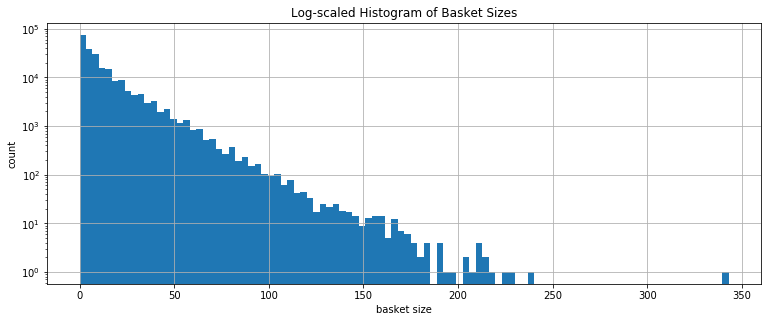

In [45]:
df_food_transactions.groupby("BASKET_ID")["QUANTITY"].sum().hist(bins=100, figsize=default_figsize)
plt.yscale("log")
plt.xlabel('basket size')
plt.ylabel('count')
plt.title('Log-scaled Histogram of Basket Sizes');

In [46]:
basket_size = df_food_transactions.groupby("BASKET_ID")["QUANTITY"].sum()
print(f"The median basket size is {int(basket_size.median())}.")

The median basket size is 6.


It seems that people have relatively small baskets in general. A possible exaplanation is that they do not make their "heavy" groceries in the stores in which the data were collected.

### Department-level Analysis

To understand what people buy, we look at the distribution of the food related transactions across the departments. 

In [47]:
transac_prod = pd.merge(df_food_transactions, df_food_products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "PAID_PRICE", "DEPARTMENT"]]

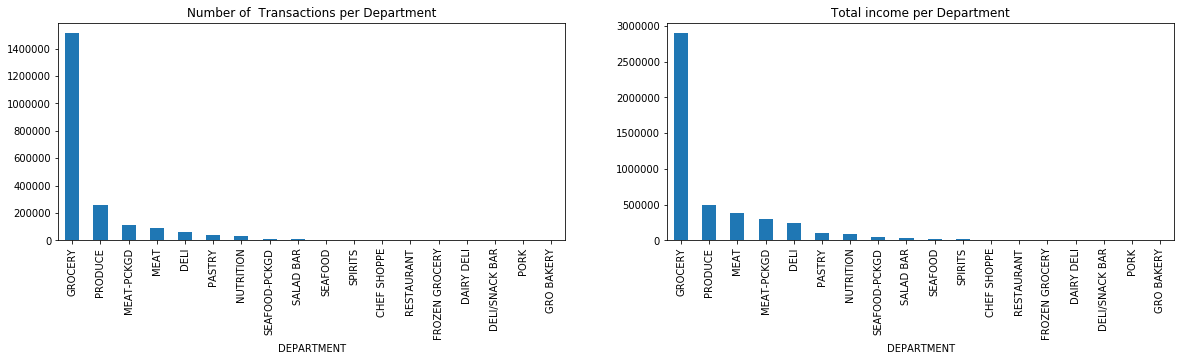

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].count().sort_values(ascending=False).plot.bar(title='Number of  Transactions per Department', ax = axes[0])
transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].sum().sort_values(ascending=False).plot.bar(title='Total income per Department', ax = axes[1]);

We observe that most of the transactions concern products of the GROCERY department which is not surprising as this is the biggest food-related department and it contains a bit of everything.

### Most sold and most profitable products

In continuity, we would also like to find out what are the most sold and most profitable products.

In [49]:
transac_prod = pd.merge(df_food_transactions, df_food_products, on="PRODUCT_ID", how="inner")

In [50]:
ranking_sells = transac_prod.groupby(['PRODUCT_ID'], as_index=False)\
            .agg({'COMMODITY_DESC': 'first', 'SUB_COMMODITY_DESC': 'first', 'PAID_PRICE': 'count'})\
            .rename(columns={"PAID_PRICE": "NUM_SOLD"})\
            .sort_values(by="NUM_SOLD", ascending=False)\
            .head(10)
ranking_sells["RANK"] = ranking_sells["NUM_SOLD"].rank(ascending=False)
ranking_sells = ranking_sells.set_index("RANK")
print("Ranking of the Most sold products: ")
ranking_sells.head(10)

Ranking of the Most sold products: 


PRODUCT_ID          COMMODITY_DESC      SUB_COMMODITY_DESC  NUM_SOLD
RANK                                                                      
1.0      1082185          TROPICAL FRUIT                 BANANAS     29778
2.0      1029743     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY     14430
3.0       995242     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY     12542
4.0      1106523     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY      9826
5.0       981760                    EGGS          EGGS - X-LARGE      9126
6.0      1133018     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY      7315
7.0       883404  BAKED BREAD/BUNS/ROLLS  MAINSTREAM WHITE BREAD      6904
8.0       951590  BAKED BREAD/BUNS/ROLLS  MAINSTREAM WHITE BREAD      6138
9.0       826249  BAKED BREAD/BUNS/ROLLS          HAMBURGER BUNS      5505
10.0      840361                    EGGS            EGGS - LARGE      5338

In [51]:
ranking_profit = transac_prod.groupby(['PRODUCT_ID'], as_index=False)\
            .agg({'COMMODITY_DESC': 'first', 'SUB_COMMODITY_DESC': 'first', 'PAID_PRICE': 'sum'})\
            .sort_values(by="PAID_PRICE", ascending=False)\
            .head(10)
ranking_profit["RANK"] = ranking_profit["PAID_PRICE"].rank(ascending=False)
ranking_profit = ranking_profit.set_index("RANK")
print("Ranking of the Most profitable products: ")
ranking_profit.head()

Ranking of the Most profitable products: 


PRODUCT_ID       COMMODITY_DESC     SUB_COMMODITY_DESC  PAID_PRICE
RANK                                                                    
1.0      1029743  FLUID MILK PRODUCTS  FLUID MILK WHITE ONLY    38451.09
2.0      1082185       TROPICAL FRUIT                BANANAS    27168.62
3.0      1106523  FLUID MILK PRODUCTS  FLUID MILK WHITE ONLY    26147.93
4.0       844179                 BEEF                 PRIMAL    14574.54
5.0      1044078                 BEEF                   LEAN    12970.96

We did not really expect Bananas to be at the the top of the ranking. As for the other products in the top 10 this was fairly predictable.

### Analysis of Weekly spending per Household

The analysis of the spending per household will be very important to answer our research questions.

In this section, we will focus on spending for meat and vegetables andfood in general. The goal is to get an idea of what are the average spending for each of them and to discover the ratio of the spendings allocated to meat and vegetables.  

In [52]:
def get_stats_meat_veggies(df_meat, df_veggies):
    """
    Returns a dataframe containg the :
      - % of transactions
      - % of spendings
    for meat and vegetables related products
    """
    indexes = ["MEAT", "VEGGIES"]
    total_spent = df_food_transactions.PAID_PRICE.sum()

    _dict = {
        "TRANSACTIONS_%": [],
        "SPENDING_%": [],
    }
    for df in df_meat, df_veggies:
        _dict["TRANSACTIONS_%"].append(int(len(df) * 100/len(df_food_transactions)))
        
        total_spent_for_cat = df.PAID_PRICE.sum()
        _dict["SPENDING_%"].append(int(((total_spent_for_cat / total_spent) * 100)))
        
    return pd.DataFrame(_dict, index=indexes)  

When looking at the average spending for a household we only consider weeks in which they bought something.

In [53]:
# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False)

We construct dataframes containing only meat related transactions as well as vegetables related transactions.

In [54]:
df_meat_transactions = pd.merge(df_meat_products, df_food_transactions, on="PRODUCT_ID", how="inner")
df_veggies_transactions = pd.merge(df_veggies_prducts, df_food_transactions, on="PRODUCT_ID", how="inner")

In [55]:
get_stats_meat_veggies(df_meat_transactions, df_veggies_transactions)

TRANSACTIONS_%  SPENDING_%
MEAT                 16          23
VEGGIES               9           7

We observe that 16% of the food related transactions are for meat products and this represnts 23% of the spendings. As for the vegetables those represent respectively 9% and 7% of the transactions and the spendings. 

We will now construct a new dataframe containing for each houselhod :
- The total amount paid for meat, vegetables and food in general
- The average spending per active week for meat, vegetables and food in general
- The ratio spend for meat and vegetables (e.g. ratio_for_meat = avg.  weekly spending for meat / avg. weekly spending for food)

In [56]:
# compute total spending for meat per household
spent_for_meat_by_household = df_meat_transactions.groupby("household_key").agg({"PAID_PRICE": sum}).reset_index()
# compute total spending for meat per household
spent_for_veggies_by_household = df_veggies_transactions.groupby("household_key").agg({"PAID_PRICE": sum}).reset_index()
# compute totatl spending for food per househould
spent_by_household = df_food_transactions.groupby("household_key").PAID_PRICE.sum()

# calculate avg. meat spending, avg. veggies, avg food spending and the ratio of meat over food spending per week

# Merge spent_for_meat and weeks_activity
spent_by_household = pd.merge(spent_for_meat_by_household, weeks_activity_by_household, on="household_key")
spent_by_household = spent_by_household.rename(columns={"PAID_PRICE_x": "paid_meat", "PAID_PRICE_y": "paid_food"})

# Merge spent_by_household and spent_for_veggie
spent_by_household = pd.merge(spent_by_household, spent_for_veggies_by_household, on="household_key")
spent_by_household = spent_by_household.rename(columns={"PAID_PRICE": "paid_veggies"})

# Compute stats for meat
spent_by_household["avg_spending_meat_per_week"] = spent_by_household.paid_meat / spent_by_household.number_of_active_weeks
spent_by_household["ratio_spent_for_meat"] = spent_by_household.avg_spending_meat_per_week / spent_by_household.avg_spending_per_week

# Compute stats for veggies
spent_by_household["avg_spending_veggies_per_week"] = spent_by_household.paid_veggies / spent_by_household.number_of_active_weeks
spent_by_household["ratio_spent_for_veggies"] = spent_by_household.avg_spending_veggies_per_week / spent_by_household.avg_spending_per_week

In [57]:
spent_by_household.head()

household_key  paid_meat  paid_food  number_of_active_weeks  \
0              1     380.95    2812.21                      67   
1              2     225.75    1082.74                      31   
2              3     567.90    1711.78                      36   
3              4     177.87     679.48                      25   
4              5     126.35     429.39                      24   

   avg_spending_per_week  paid_veggies  avg_spending_meat_per_week  \
0              41.973284        292.81                    5.685821   
1              34.927097         58.14                    7.282258   
2              47.549444         41.01                   15.775000   
3              27.179200          9.70                    7.114800   
4              17.891250         10.49                    5.264583   

   ratio_spent_for_meat  avg_spending_veggies_per_week  \
0              0.135463                       4.370299   
1              0.208499                       1.875484   
2              0.331760                       1.139167   
3              0.261774                       0.388000   
4              0.294255                       0.437083   

   ratio_spent_for_veggies  
0                 0.104121  
1                 0.053697  
2                 0.023958  
3                 0.014276  
4                 0.024430

We can look at the distribution of the average spending per week :

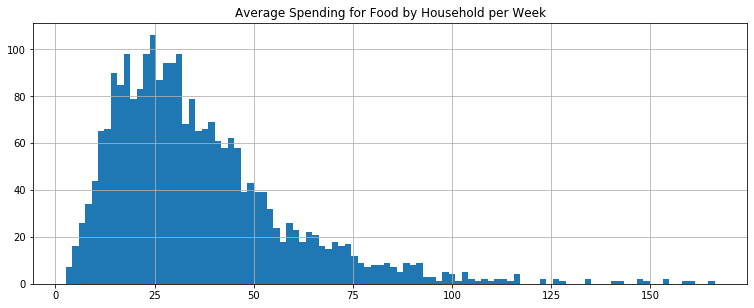

In [58]:
spent_by_household.avg_spending_per_week.hist(bins=100, figsize=default_figsize)
plt.title("Average Spending for Food by Household per Week")
plt.show();

We can also compare the spendings for meat with the spending for vegetables :

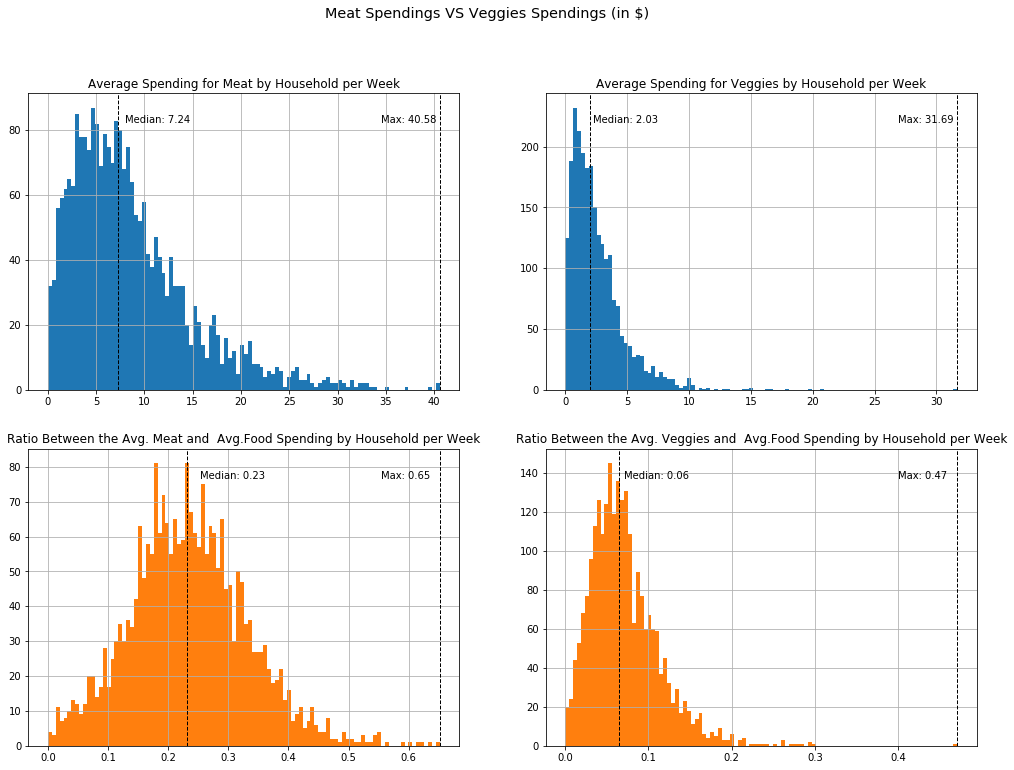

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,12))
to_plot = {
    "Average Spending for Meat by Household per Week": spent_by_household.avg_spending_meat_per_week,
    "Average Spending for Veggies by Household per Week": spent_by_household.avg_spending_veggies_per_week,
    "Ratio Between the Avg. Meat and  Avg.Food Spending by Household per Week": spent_by_household.ratio_spent_for_meat,
    "Ratio Between the Avg. Veggies and  Avg.Food Spending by Household per Week": spent_by_household.ratio_spent_for_veggies
}

for i, (title, data) in enumerate(to_plot.items()):
    color = "tab:orange" if i > 1 else "tab:blue" 
    ax =  axes[i // 2][i % 2]
    median = data.median()
    _max = data.max()
    
    data.hist(bins=100, ax=ax, color=color)
    min_ylim, max_ylim = ax.get_ylim()
    ax.set_title(title)
    ax.axvline(median, color='k', linestyle='dashed', linewidth=1)
    ax.axvline(_max, color='k', linestyle='dashed', linewidth=1)
    ax.text(median*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(median))
    ax.text(_max*0.85, max_ylim*0.9, 'Max: {:.2f}'.format(_max))
    
st = fig.suptitle("Meat Spendings VS Veggies Spendings (in $)", fontsize="x-large")
plt.show();

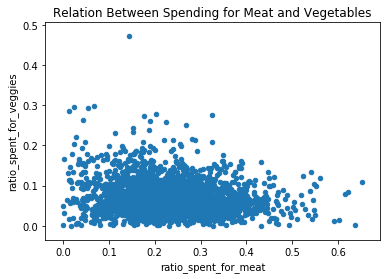

In [60]:
spent_by_household.plot.scatter(x="ratio_spent_for_meat", y="ratio_spent_for_veggies")
plt.title('Relation Between Spending for Meat and Vegetables');

There seems to be no linear correlation between the spending for meat and vegetables.

### Biggest meat consumers VS biggest veggies consumer

We are also interested in looking at the consumption of the big meat and vegetables spenders. What are the other types of products that they buy ?

To do this analysis, we consider households as big meat/vegeatables if  they are in the 4th quartile of meat/vegetables spendings.

In [61]:
def get_transactions(spending_type, quantile):
    # Get the transactions of the biggest meat consumers
    quantile = spending_type.quantile(quantile)
    households = spent_by_household[spending_type > quantile].household_key.values
    transactions = df_food_transactions[df_food_transactions.household_key.isin(households)]
    transactions_with_prod_info = pd.merge(transactions, df_products, how="inner")    
    return list(households), transactions_with_prod_info

biggest_meat_buyers, biggest_meat_consumers_transactions = get_transactions(spent_by_household.ratio_spent_for_meat, quantile=0.75)
biggest_veggies_buyers, biggest_veggie_consumers_transactions = get_transactions(spent_by_household.ratio_spent_for_veggies, quantile=0.75)

print(f"The 4th quartile corresponds to {len(biggest_veggies_buyers)} households")

households_in_both = list(set(biggest_meat_buyers).intersection(biggest_veggies_buyers))
print(f"Out of those {len(biggest_veggies_buyers)} household, {len(households_in_both)} of them (={round((len(households_in_both) / len(biggest_meat_buyers)) * 100, 2)}%) are both bigh meat buyers and big veggies buyers.")

The 4th quartile corresponds to 607 households
Out of those 607 household, 110 of them (=18.12%) are both bigh meat buyers and big veggies buyers.


We only consider households that appear in one of the two groups. Doing that we have two disting groups of people.

In [62]:
# Remove houselds that are in the two groups
biggest_meat_consumers_transactions = biggest_meat_consumers_transactions[~biggest_meat_consumers_transactions.household_key.isin(households_in_both)]
biggest_veggie_consumers_transactions = biggest_veggie_consumers_transactions[~biggest_veggie_consumers_transactions.household_key.isin(households_in_both)]

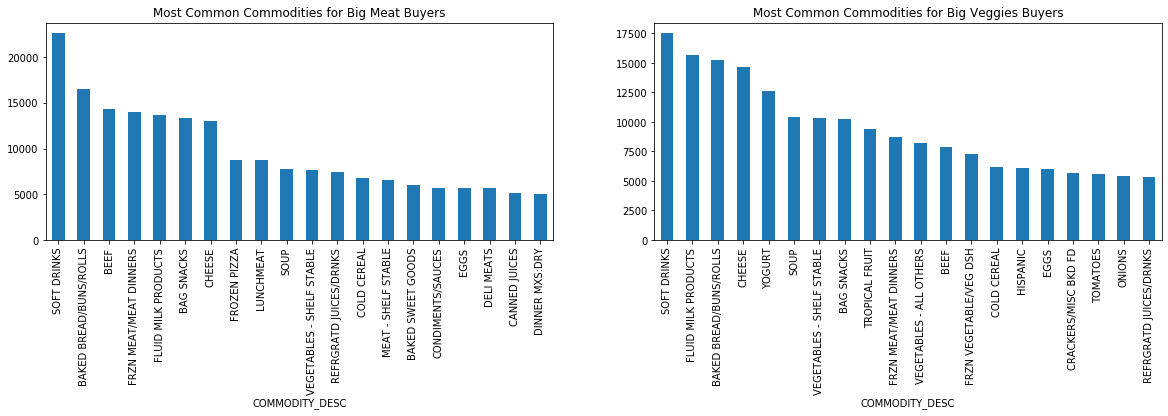

In [63]:
# Look at the 15 most common commodities for each group
top_15_meat = biggest_meat_consumers_transactions.groupby("COMMODITY_DESC")["household_key"]\
                                   .count()\
                                   .sort_values(ascending=False)[:20]
top_15_veggies = biggest_veggie_consumers_transactions.groupby("COMMODITY_DESC")["household_key"]\
                                     .count()\
                                     .sort_values(ascending=False)[:20]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
top_15_meat.plot.bar(ax=axes[0]);
top_15_veggies.plot.bar(ax=axes[1]);
axes[0].set_title("Most Common Commodities for Big Meat Buyers");
axes[1].set_title("Most Common Commodities for Big Veggies Buyers");

We observe in the two plots that although there are some similiraties we also notice some differences. For example, big veggies spenders buy way more yoghourt than big meat buyers.

We can compare the 2 groups on some selected commodities :

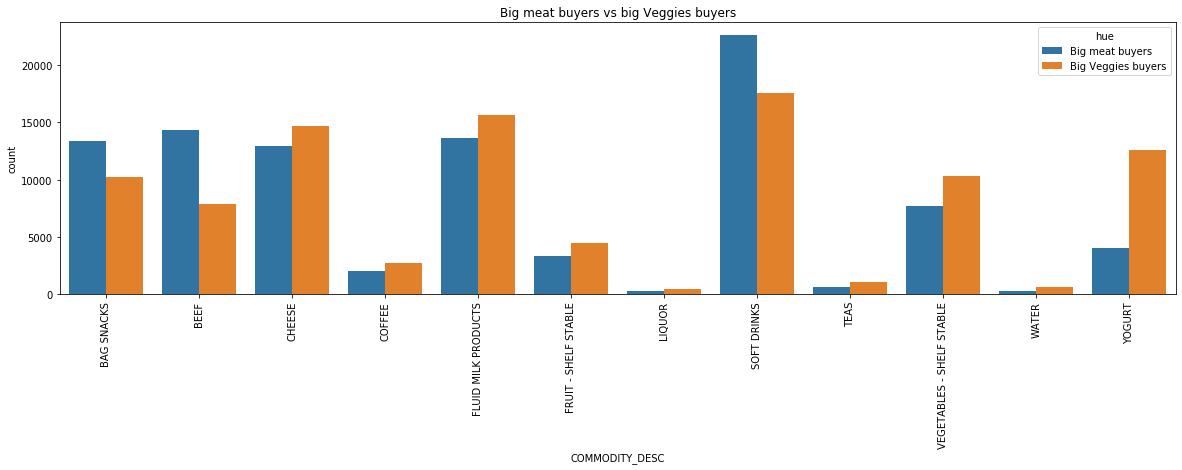

In [64]:
# Compare the 2 groups on some selected commodities
selected_commodities = [
    "FRUIT - SHELF STABLE",
    "SOFT DRINKS",
    "BAG SNACKS",
    "YOGURT",
    "CHEESE",
    "FLUID MILK PRODUCTS",
    "COFFEE",
    "TEAS",
    "VEGETABLES - SHELF STABLE",
    "BEEF",
    "LIQUOR",
    "WATER",
]

def get_count_by_commodity(df, commodities):
    filtered = df[df.COMMODITY_DESC.isin(commodities)]
    return filtered[["COMMODITY_DESC"]].reset_index().groupby("COMMODITY_DESC")["index"].count().reset_index(name="count")

counts_per_commodity_meat = get_count_by_commodity(biggest_meat_consumers_transactions, selected_commodities)
counts_per_commodity_veggies = get_count_by_commodity(biggest_veggie_consumers_transactions, selected_commodities)

counts_per_commodity_meat['hue']="Big meat buyers"
counts_per_commodity_veggies['hue']="Big Veggies buyers"
res=pd.concat([counts_per_commodity_meat, counts_per_commodity_veggies])

plt.figure(figsize=(20,5))
plt.title ("Big meat buyers vs big Veggies buyers")
plot = sns.barplot(x='COMMODITY_DESC',y='count',data=res,hue='hue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

## Analysis of Coupons

In [65]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv', sep = ',')
df_coupon.head()

COUPON_UPC  PRODUCT_ID  CAMPAIGN
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25

In [66]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv', sep = ',')
df_coupon_redempt.head()

household_key  DAY   COUPON_UPC  CAMPAIGN
0              1  421  10000085364         8
1              1  421  51700010076         8
2              1  427  54200000033         8
3              1  597  10000085476        18
4              1  597  54200029176        18

In [67]:
print('There are {0} rows and {1} columns in the df_coupon.'.format(len(df_coupon), len(df_coupon.columns)))
print('There are {0} rows and {1} columns in the df_coupon_redempt.'.format(len(df_coupon_redempt), len(df_coupon_redempt.columns)))
print('Number of columns with missing values for df_coupon is {0}.'.format(len(df_coupon.columns.to_numpy()[df_coupon.isna().any()])))
print('Number of columns with missing values for df_coupon_redempt is {0}.'.format(len(df_coupon_redempt.columns.to_numpy()[df_coupon_redempt.isna().any()])))

There are 124548 rows and 3 columns in the df_coupon.
There are 2318 rows and 4 columns in the df_coupon_redempt.
Number of columns with missing values for df_coupon is 0.
Number of columns with missing values for df_coupon_redempt is 0.


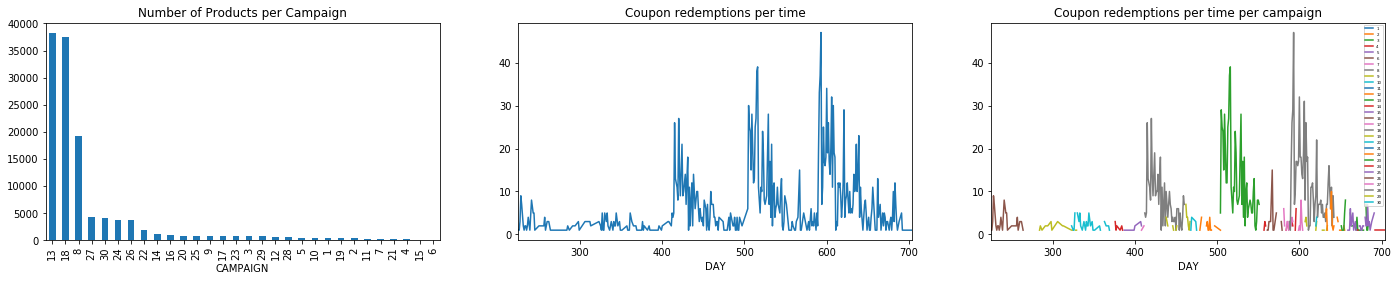

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,4))
df_coupon.groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False).plot.bar(ax=axes[0])
axes[0].set_title("Number of Products per Campaign")

df_coupon_redempt.groupby('DAY')['household_key'].count().plot(ax=axes[1])
axes[1].set_title("Coupon redemptions per time")
df_coupon_redempt.groupby(['CAMPAIGN', 'DAY'])['household_key'].count().reset_index().pivot('DAY', 'CAMPAIGN', 'household_key').plot(ax=axes[2])
axes[2].set_title("Coupon redemptions per time per campaign")
plt.legend(prop={'size': 4});

We observe that there are three campaigns that are distinctively more popular and trending than others, namely, 13, 18 and 8. Those campaigns also last longer (around 75 days) than other campaigns.

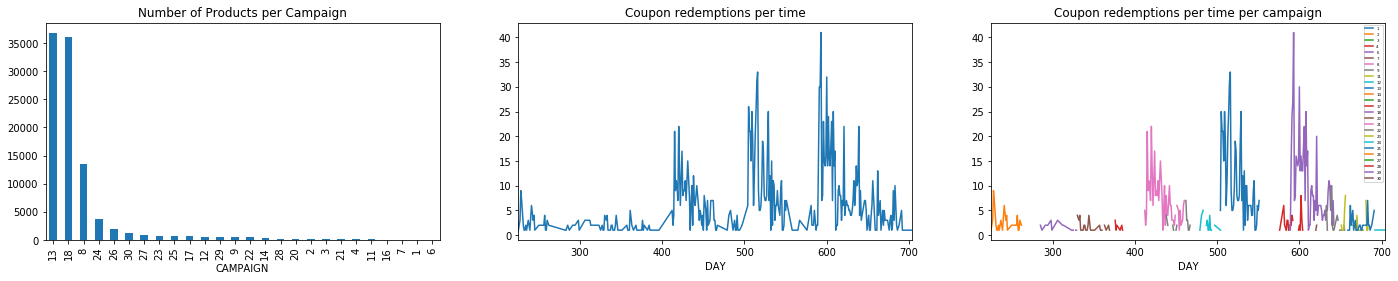

In [69]:
# merge coupon dataframes and filter by food products
df_coupon_and_redempt = pd.merge(df_coupon, df_coupon_redempt, on='COUPON_UPC', how='inner')
df_coupon_and_redempt_for_food = df_coupon_and_redempt[df_coupon_and_redempt.PRODUCT_ID.isin(df_food_products.PRODUCT_ID)]\
    .drop('CAMPAIGN_y', axis=1).rename(columns={'CAMPAIGN_x': 'CAMPAIGN'})
food_coupons = df_coupon_and_redempt_for_food.COUPON_UPC.unique()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,4))
df_coupon[df_coupon.COUPON_UPC.isin(food_coupons)].groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False).plot.bar(ax=axes[0])
axes[0].set_title("Number of Products per Campaign")

df_coupon_redempt[df_coupon_redempt.COUPON_UPC.isin(food_coupons)].groupby('DAY')['household_key'].count().plot(ax=axes[1])
axes[1].set_title("Coupon redemptions per time")
df_coupon_redempt[df_coupon_redempt.COUPON_UPC.isin(food_coupons)].groupby(['CAMPAIGN', 'DAY'])['household_key'].count().reset_index().pivot('DAY', 'CAMPAIGN', 'household_key').plot(ax=axes[2])
axes[2].set_title("Coupon redemptions per time per campaign")
plt.legend(prop={'size': 4});

Furthermore, we observe that most popular three campaigns contain many food coupons. Therefore, there are related with foods.

## Combined Analysis

In this section, we look at the impact of some demographic features on the average weekly spendings for food in general and meat.

In [70]:
df_spent_and_demog=pd.merge(df_household, spent_by_household, on='household_key', how='inner')

In [71]:
def plot_weekly_spending(df, demographic_feature, feature_name, order=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
    chart = sns.barplot(x = demographic_feature, y ='avg_spending_per_week', data = df, ax = axes[0], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[0].set_title(f'Average Weekly Spending on Food a.t. {feature_name}')
    chart = sns.barplot(x = demographic_feature, y ='avg_spending_meat_per_week', data = df, ax = axes[1], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[1].set_title(f'Average Weekly Spending on Meat a.t. {feature_name}')
    chart = sns.barplot(x = demographic_feature, y ='ratio_spent_for_meat', data = df, ax = axes[2], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[2].set_title(f'Ratio Between weekly Avg. Meat and  Avg.Food Spending a.t. {feature_name}');

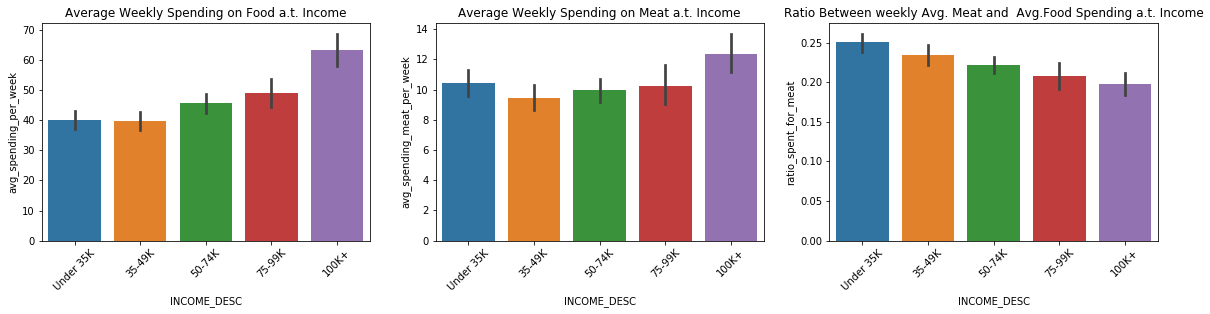

In [72]:
plot_weekly_spending(df_spent_and_demog, 'INCOME_DESC', 'Income', order=["Under 35K", "35-49K", "50-74K", "75-99K", "100K+"])

As expected, richer people spend more on food gloally (see left plot). Looking at the righmost graph, we observe that the ratio spent for meat seems to be lower for richer people. This has to be further investigated. However, we can already see that the meat consumption is less influenced by the income than the overall food consumption.

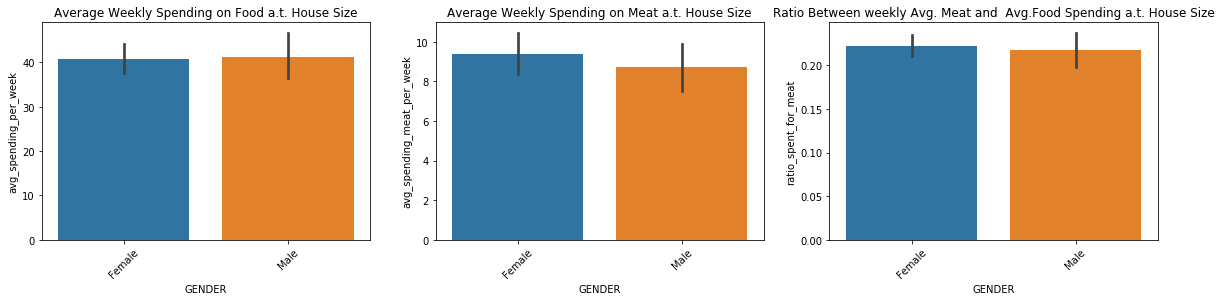

In [73]:
plot_weekly_spending(df_spent_and_demog, 'GENDER', 'House Size')

We observe that there seems to be no difference between the spendings of males and females.

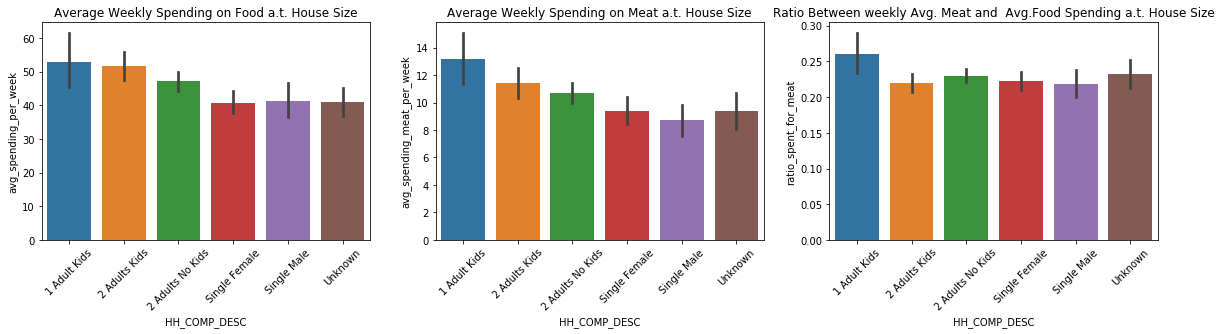

In [74]:
plot_weekly_spending(df_spent_and_demog, 'HH_COMP_DESC', 'House Size')

At first sight, we do not observe any relation between the household composition and the meat consumption.

## Future Work

Here are some topics that we plan to explore before the newt milestone :

#### An analysis with combined demographics 
We want to go more in depth in the analysis of the impact of demographic features on meat comsumption. Looking at each feature independantly of the other might not be enough for us to draw interesting conclusions. Combining some demographics features such as age and income might be worth to try.

#### An analyis with subsets of meat / vegetable types
It could be interesting to invetigate our research questions but instead of looking at meat in general, to look at the consumptions of different types of meat (ovine, bovine, ...). 

#### Track seaosonal changes
As we now have the dates of the transactions, it is possible for us to track the seasonal changes of meat comsuption.
A nice way to visualize those changes would be the use of a calendar heatmap.

####  Mathematical methods
As the core of our project is mainly to compare different populations of shoppers (e.g. frequent meat consumers vs frequent vegetables consumers), we need some methods to compare those groups.

We can use some similarity metrics, such as Jaccard similarity, to assess the differences/similarities of those sets of consumers. Moreover, we plan to use statistical methods for hypothesis testing. This will be useful to assess if there is a difference between the meat comsuption of two demographic groups.

Lastly, we can use ANOVA which is suited to investigate the correlation between a categorical variable (e.g. big meat buyer vs big veggies buyer) and a continious variable (e.g. spendings). 